# Prep Course - Assignment / Rodrigo Freitas

## Connection to the local database

In [25]:
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

db = mysql.connector.connect(
    host="localhost",
    port="3306",
    user="anyuser",
    passwd="anypwd",
    use_pure=True,
    database="kickstarter"
)

sns.set(style="whitegrid")

### Question 1) how goals and outcomes are related?
For the sake of simplicity on handling currency, this analysis will encompass only USD goals.

goal
outcome                 
canceled    4.596517e+04
failed      1.016530e+05
live        5.143138e+04
successful  9.975665e+03
suspended   1.943697e+06
undefined   4.144643e+03


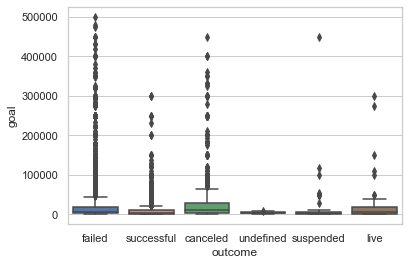

In [26]:
df_q1 = pd.read_sql_query("SELECT campaign.goal, campaign.outcome, currency.name FROM campaign, currency WHERE currency.id = campaign.currency_id AND (currency.name = 'USD') LIMIT 20000", db)

print(df_q1.groupby("outcome").mean())

dfGoalsBelowFiveHundredThousand = df_q1[df_q1.goal < 500000]
# ax = sns.boxplot(x=df.outcome, y=df.goal, data=df)
sns.boxplot(x=dfGoalsBelowFiveHundredThousand.outcome, y=dfGoalsBelowFiveHundredThousand.goal, data=dfGoalsBelowFiveHundredThousand)

- Failed and canceled outcomes present larger goals than successful ones.
- to compare: successful outcomes average 9,977 USD, while failed, 101,653 USD



### Question 2) How do successful and unsuccessful campaigns differ in terms of numbers of backers?

In [27]:
df_q2 = pd.read_sql_query("SELECT campaign.backers, campaign.outcome FROM campaign LIMIT 20000", db)
print(df_q2.groupby("outcome").describe())

backers                                                           
             count        mean          std  min   25%   50%    75%       max
outcome                                                                      
canceled    1513.0   20.777925    57.662270  0.0   0.0   2.0   15.0     613.0
failed      7850.0   17.721529    92.058042  0.0   1.0   3.0   13.0    4201.0
live         110.0   24.654545    59.152646  0.0   1.0   3.5   18.0     425.0
successful  5319.0  282.145140  1898.344694  0.0  34.0  70.0  165.0  105857.0
suspended     68.0   39.632353   114.731862  0.0   0.0   2.5   21.5     683.0
undefined    140.0    0.000000     0.000000  0.0   0.0   0.0    0.0       0.0


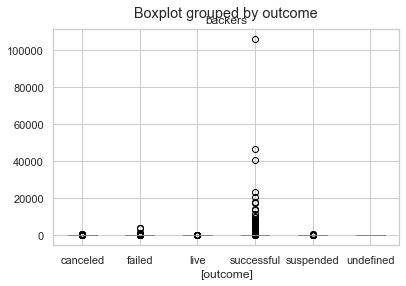

In [28]:
df_q2.boxplot(by="outcome")

- Successful outcomes on average have more backers than the canceled ones (282.15 against 17.72)
- Also, the largest amount of backers for a successful outcome is 105,857, which is around 25 times larger than the failed ones.

3. Which categories/subcategories are commonly successful and unsuccessful?

In [29]:
dfQ3 = pd.read_sql_query("SELECT campaign.outcome, sub_category.name AS sub_category_name, category.name as category_name FROM campaign JOIN sub_category ON campaign.sub_category_id = sub_category.id JOIN category ON sub_category.category_id = category.id LIMIT 20000", db)

print(dfQ3[dfQ3.outcome == "failed"].groupby("category_name").count())

print(dfQ3[dfQ3.outcome == "successful"].groupby("category_name").count())

outcome  sub_category_name
category_name                            
Art                571                571
Comics             156                156
Crafts             220                220
Dance               39                 39
Design             610                610
Fashion            549                549
Film & Video      1368               1368
Food               607                607
Games              609                609
Journalism          78                 78
Music              851                851
Photography        241                241
Publishing         936                936
Technology         843                843
Theater            172                172
               outcome  sub_category_name
category_name                            
Art                433                433
Comics             244                244
Crafts              90                 90
Dance               82                 82
Design             425                425
Fashion

- unsuccessful: 
    - the most unsuccessful campaigns: games (253), film & video (217) and Design (194)
- successful:
    - Music (970), Film & video (940) and Publishing (510)

In [30]:
print(dfQ3[dfQ3.outcome == "failed"].groupby("sub_category_name").count().outcome.nlargest(5))

sub_category_name
Product Design    447
Documentary       381
Video Games       269
Food              256
Fiction           251
Name: outcome, dtype: int64


In [31]:
print(dfQ3[dfQ3.outcome == "successful"].groupby("sub_category_name").count().outcome.nlargest(5))

sub_category_name
Product Design    336
Tabletop Games    294
Shorts            277
Music             272
Documentary       248
Name: outcome, dtype: int64


- subcategories
    - successful: Product Design, Tabletop Games, shorts
    - top unsuccessful: Product Design, Video Games and TabletopGames

- in general
    - games and product design are the most predominant categories

### 4) How are the pledge/donation amounts and rewards commonly related?
- there's no information about the rewards, thus, as a proxy, it'll be analyzed the category, to check for any relation between it and the amount of pledge

In [32]:
dfQ4 = pd.read_sql_query("SELECT category.name, campaign.pledged, campaign.outcome FROM campaign \
JOIN sub_category ON campaign.sub_category_id = sub_category.id \
JOIN category ON sub_category.category_id = category.id \
LIMIT 20000", db)

print(dfQ4[dfQ4.outcome == "successful"].groupby(["name"]).describe())

# top 5
print(dfQ4[dfQ4.outcome == "successful"].groupby("name").sum().pledged.nlargest(5))

pledged                                                  \
               count          mean            std     min        25%   
name                                                                   
Art            433.0  10339.329677   92872.223046   15.00  1020.0000   
Comics         244.0  10223.864754   21498.808235  107.00  1735.7500   
Crafts          90.0   5232.254667    9285.974556   46.30   576.2500   
Dance           82.0   5525.681463    5207.648080  270.87  2262.9150   
Design         425.0  50114.465624  127515.649643   43.00  4611.0000   
Fashion        218.0  21738.692523   48820.873589   23.00  2125.2500   
Film & Video   940.0  17832.650638  110650.946076   25.00  1938.0000   
Food           252.0  15875.692421   44141.932400   12.00  3811.3925   
Games          461.0  54617.044555  248161.688912   74.00  4160.0000   
Journalism      31.0  13673.660000   27606.248519  565.00  1630.8900   
Music          970.0   6734.600515    9949.031783   10.00  1879.7500   
Photo

There's again, a predominance of Games, Tech and Design categories.

### 5) Is there an impact on the duration of the campaign?

In [33]:
dfQ5 = pd.read_sql_query("SELECT campaign.outcome, DATEDIFF(campaign.deadline, campaign.launched) AS durationInDays \
FROM campaign \
LIMIT 20000", db)

print(dfQ5.describe())

print(dfQ5.groupby("outcome").describe())


durationInDays
count    15000.000000
mean        34.307067
std         12.945824
min          1.000000
25%         30.000000
50%         30.000000
75%         37.000000
max         92.000000
           durationInDays                                                    
                    count       mean        std   min   25%   50%   75%   max
outcome                                                                      
canceled           1513.0  36.153338  13.202694   3.0  30.0  30.0  42.0  90.0
failed             7850.0  35.116178  13.215484   1.0  30.0  30.0  40.0  92.0
live                110.0  39.954545  13.469903  17.0  30.0  30.0  60.0  60.0
successful         5319.0  32.449709  12.170967   1.0  30.0  30.0  35.0  91.0
suspended            68.0  36.250000  17.861302   5.0  30.0  30.0  46.0  90.0
undefined           140.0  34.171429  11.390987   8.0  30.0  30.0  40.0  60.0


- the campaign's outcomes doesn't seem to change change expressively with the duration
- independetly of the outcome, the duration is between 30 to 40 days on average.
- successful campaigns on average finish a little faster than the others.


### 6) What are year-over-year trends Kickstarter campaigns that can help assess it as a platform?

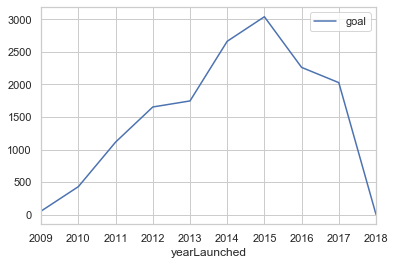

In [34]:
dfQ6 = pd.read_sql_query("SELECT YEAR(campaign.launched) as yearLaunched, campaign.outcome, campaign.goal \
FROM campaign \
LIMIT 20000", db)

dfQ6Grouped = dfQ6.groupby(["yearLaunched"]).count()["goal"].reset_index().plot(x="yearLaunched")
# print"].groupby(["outcome", "yearLaunched"]))
# print(dfQ6.groupby(["outcome", "yearLaunched"]).count().set_index(["outcome", "yearLaunched"]))

# fig, ax = plt.subplots(figsize=(15,7))
# dfQ6.groupby(["outcome", "yearLaunched"]).count().outcome.unstack().plot(ax=ax)
# dfQ6Grouped.count().plot()


- kickstarter reached a peak in 2015, and after that the amount of campaigns has been decreasing.
- it has no evidence of a new growth yoy, however, the amount of campaigs is still high, around 2.000 in 2017.

### 7) (own question) What are the top category trends?

plotmap     categoryName  year  count
0            Art  2009      2
1            Art  2010     14
2            Art  2011     24
3            Art  2012     42
4            Art  2013     28
5            Art  2014     17
6            Art  2015     15
7            Art  2016      6
8            Art  2017      5
9         Comics  2010      2
10        Comics  2011     13
11        Comics  2012     14
12        Comics  2013     43
13        Comics  2014     46
14        Comics  2015     60
15        Comics  2016     72
16        Comics  2017     86
17        Crafts  2009      1
18        Crafts  2010      2
19        Crafts  2011      9
20        Crafts  2012     25
21        Crafts  2013     37
22        Crafts  2014     22
23        Crafts  2015     15
24        Crafts  2016      4
25        Crafts  2017      7
26         Dance  2010      1
27         Dance  2011      6
28         Dance  2012     19
29         Dance  2013     46
..           ...   ...    ...
85   Photography  2011      1
86

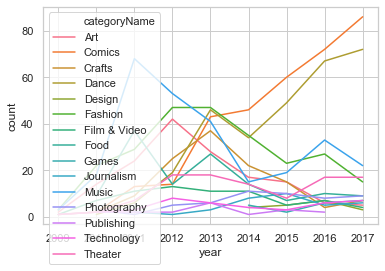

In [167]:
dfQ7 = pd.read_sql_query("SELECT YEAR(campaign.launched) as yearLaunched, campaign.outcome, category.name \
FROM campaign \
JOIN sub_category ON campaign.sub_category_id = sub_category.id \
JOIN category on sub_category.id = category.id \
LIMIT 20000", db)

# print(dfQ7.pivot(columns=["outcome", "yearLaunched"])
# print(dfQ7[(dfQ7.outcome == "successful")].groupby(by=["name", "yearLaunched"])["yearLaunched"].groups)


gr7 = dfQ7[(dfQ7.outcome == "successful")].groupby(by=["name", "yearLaunched"]).count().outcome

type(gr7)

x = map(lambda item: (item[0][0], item[0][1], item[1]), gr7.items())

d7plot = pd.DataFrame(list(x), columns=["categoryName", "year", "count"])
print("plotmap", d7plot)

# sns.load_dataset(d7plot)
ax = sns.lineplot(x="year", y="count", hue="categoryName", data=d7plot)

# for index, value in gr7.items():
# #     print(index, value)
#     d7plot = d7plot.append({"categoryName": index[0], "year":index[1], "count": value}, ignore_index=True)




- analyzing the successful campaigns, the most-growing trends are comics and dance, while music has reduced from around 70% from 2012 to 2017.

### 8) (own question) Is there an impact on the country on the final outcome?

countryName
AT         3
AU        84
BE         4
CA       137
CH        10
DE        36
DK        16
ES        13
FR        29
GB       487
HK         8
IE        10
IT        15
LU         2
MX        20
N,0"       7
NL        28
NO         8
NZ        14
SE        15
SG         8
US      4365
Name: outcome, dtype: int64
countryName
AT         27
AU        313
BE         16
CA        588
CH         35
DE        148
DK         48
ES         84
FR        106
GB       1304
HK         24
IE         36
IT        121
LU          3
MX         70
N,0"      155
NL        104
NO         26
NZ         57
SE         67
SG         19
US      11649
Name: outcome, dtype: int64
   country  successful  total  succ./total
0       AT           3     27     0.111111
1       AU          84    313     0.268371
2       BE           4     16     0.250000
3       CA         137    588     0.232993
4       CH          10     35     0.285714
5       DE          36    148     0.243243
6       DK          16   

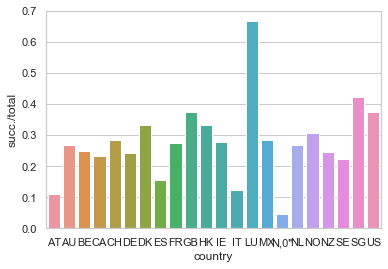

In [211]:
dfQ8 = pd.read_sql_query("SELECT campaign.outcome, country.name AS countryName \
FROM campaign \
JOIN country ON campaign.country_id = country.id \
LIMIT 20000", db)

print(dfQ8[dfQ8.outcome == "successful"].groupby(["countryName"]).count().outcome)

successfulList=dfQ8[dfQ8.outcome == "successful"].groupby(["countryName"]).count().outcome.items()
allList=dfQ8.groupby(["countryName"]).count().outcome.items()
zipped = zip(successfulList, allList)

# x = map(lambda item: (item[0][0], item[0][1], item[1]), gr7.items())
# d7plot = pd.DataFrame(list(x), columns=["categoryName", "year", "count"])

q8map = map(lambda x: (x[0][0], x[0][1], x[1][1], x[0][1]/x[1][1]), zipped)
dfhandled = pd.DataFrame(list(q8map), columns=["country", "successful", "total", "succ./total"])

print(dfhandled)

ax = sns.barplot(x="country", y="succ./total", data=dfhandled)

- richest countries present higher rate of success (LU, SG, GB and US), however the samples are much smaller than that of US.

### 9) (own question) what are the countries with the most campaigns?


country  successful  total  succ./total
0       AT           3     27     0.111111
1       AU          84    313     0.268371
2       BE           4     16     0.250000
3       CA         137    588     0.232993
4       CH          10     35     0.285714
5       DE          36    148     0.243243
6       DK          16     48     0.333333
7       ES          13     84     0.154762
8       FR          29    106     0.273585
9       GB         487   1304     0.373466
10      HK           8     24     0.333333
11      IE          10     36     0.277778
12      IT          15    121     0.123967
13      LU           2      3     0.666667
14      MX          20     70     0.285714
15    N,0"           7    155     0.045161
16      NL          28    104     0.269231
17      NO           8     26     0.307692
18      NZ          14     57     0.245614
19      SE          15     67     0.223881
20      SG           8     19     0.421053
21      US        4365  11649     0.374710


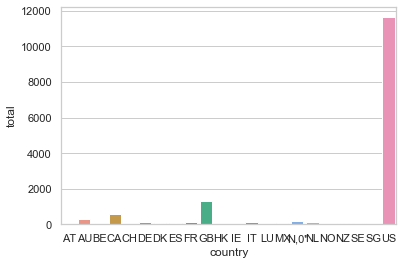

In [214]:
ax = sns.barplot(x="country", y="total", data=dfhandled)
print(dfhandled)

- US, by ten times the second country, GB.

In [ ]:
## Recommendations


## Appendix
### SQL commands used to answer the questions

```
SELECT campaign.goal, campaign.outcome, currency.name
FROM campaign, currency
WHERE currency.id = campaign.currency_id AND (currency.name = "USD")
LIMIT 20000
```

```
SELECT campaign.backers, campaign.outcome
FROM campaign
LIMIT 20000
```


```
SELECT campaign.name, campaign.outcome, campaign.sub_category_id, sub_category.name AS sub_category_name, category.name as category_name
FROM campaign
JOIN sub_category ON campaign.sub_category_id = sub_category.id
JOIN category ON sub_category.category_id = category.id
LIMIT 20000

```


```
SELECT campaign.pledged, sub_category.name
FROM campaign
JOIN sub_category ON campaign.sub_category_id = sub_category.id
LIMIT 20000
```

```
SELECT category.name, campaign.pledged FROM campaign 
JOIN sub_category ON campaign.sub_category_id = sub_category.id 
JOIN category ON sub_category.category_id = category.id
LIMIT 20000
```

```
SELECT campaign.outcome, datediff(campaign.deadline, campaign.launched) AS durationInDays
FROM campaign
LIMIT 20000
```


```
SELECT YEAR(campaign.launched) as yearLaunched, campaign.outcome, campaign.goal 
FROM campaign
LIMIT 20000
```



```
SELECT YEAR(campaign.launched) as yearLaunched, campaign.outcome, category.name
FROM campaign
JOIN sub_category ON campaign.sub_category_id = sub_category.id
JOIN category on sub_category.id = category.id
LIMIT 20000
```

```
SELECT YEAR(campaign.launched) as yearLaunched, campaign.outcome, country.name AS countryName
FROM campaign
JOIN country ON campaign.country_id = country.id
LIMIT 20000
```
